<h1>laser_cutting_model<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка-к-эксперименту" data-toc-modified-id="Подготовка-к-эксперименту-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка к эксперименту</a></span><ul class="toc-item"><li><span><a href="#План-предобработки" data-toc-modified-id="План-предобработки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>План предобработки</a></span></li><li><span><a href="#Эксперимент" data-toc-modified-id="Эксперимент-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Эксперимент</a></span></li><li><span><a href="#&quot;Pipeline&quot;" data-toc-modified-id="&quot;Pipeline&quot;-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>"Pipeline"</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Разделим-на-выборки" data-toc-modified-id="Разделим-на-выборки-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Разделим на выборки</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Стандартная-линейная-регрессия" data-toc-modified-id="Стандартная-линейная-регрессия-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>Стандартная линейная регрессия</a></span></li></ul></li><li><span><a href="#Сравнение-baseline-и-regression" data-toc-modified-id="Сравнение-baseline-и-regression-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Сравнение baseline и regression</a></span></li><li><span><a href="#Улучшение-модели-(регуляризация)" data-toc-modified-id="Улучшение-модели-(регуляризация)-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Улучшение модели (регуляризация)</a></span><ul class="toc-item"><li><span><a href="#lasso" data-toc-modified-id="lasso-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>lasso</a></span></li><li><span><a href="#ridge" data-toc-modified-id="ridge-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>ridge</a></span></li><li><span><a href="#ElasticNet" data-toc-modified-id="ElasticNet-2.6.3"><span class="toc-item-num">2.6.3&nbsp;&nbsp;</span>ElasticNet</a></span></li></ul></li><li><span><a href="#Сравнение-результатов" data-toc-modified-id="Сравнение-результатов-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Сравнение результатов</a></span></li><li><span><a href="#Улучшение-модели-(полином)" data-toc-modified-id="Улучшение-модели-(полином)-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Улучшение модели (полином)</a></span></li></ul></li><li><span><a href="#Визуализация-результатов" data-toc-modified-id="Визуализация-результатов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Визуализация результатов</a></span></li><li><span><a href="#Итог" data-toc-modified-id="Итог-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итог</a></span></li></ul></div>

# Импорт библиотек

Импорты и функции вынесены в отдельный файл

In [1]:
import sys
sys.path.append('../')

In [2]:
from src.utils import *

# Подготовка к эксперименту 

Загрузим данные и сразу переименуем признаки

In [3]:
link = "../data/laser_cutting.csv"
data = pd.read_csv(link, on_bad_lines="skip")
data.rename(columns={'Наименование': 'Part_name',
                        'Материал': 'Material',
                        'Время': 'Time',
                        'Ширина': 'Width',
                        'Длина': 'Length',
                        'Длина реза': 'Cut_length',
                        'Кол-во резов': 'Cut_quantity',
                        'Операция': 'Operation'}, inplace=True)

In [4]:
data.head()

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity
0,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
1,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
2,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
3,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
4,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1


Удаляем дубли по hash

In [5]:
data.drop_duplicates(subset='hash', inplace=True)

Проведем эксперимент,

за baseline возьмем предсказание по формуле t = V*S,

обучать будем модель решающего дерева

Параметры предобработки запишем в pre_params

In [6]:
pre_params = dict()

## Предобработка

Скопируем данные для перевого эксперимента

In [7]:
exp1 = data.copy()

Не будем удалять дубли в наименовании изделия

In [8]:
pre_params['part_name'] = 'drop_duplicated: False'

Добавим признак keywords

In [9]:
pre_params['new_features'] = ['keywords_count: (part_name, add_keywords)']

In [10]:
exp1 = add_keywords(exp1, 'Part_name')
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count
0,круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1,[круг],8.000
14,"след 1,3 ст3.л3,0","Лист х/к т. 3,0 мм.",ЛР,42d871d3ed,00:00:07.5,62.000,111.000,304,1,"[след, стл]",3.000
17,100-15.214.03 перекладина низ,"Труба проф. 40*40*2,0",ТР,1588a8230e,00:00:46.7,356.000,155.000,581,12,"[перекладина, низ]",93.000


Добавим признак - тип материала

In [11]:
pre_params['new_features'].append(['material_mark: (material, get_material_mark)'])

In [12]:
exp1['Material']=exp1['Material'].apply(lambda x: x.strip().lower())
exp1['Material_mark'] = exp1['Material'].apply(get_material_mark)
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1,[круг],8.000,Сталь
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,00:00:07.5,62.000,111.000,304,1,"[след, стл]",3.000,Сталь
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,00:00:46.7,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь


Добавим толщину

In [13]:
pre_params['new_features'].append(['thickness: (material, extract_thikness)'])

In [14]:
exp1['Thickness'] = exp1['Material'].apply(extract_thickness)
exp1 = exp1[exp1['Thickness']!='Ошибка']
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark,Thickness
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1,[круг],8.000,Сталь,3.000
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,00:00:07.5,62.000,111.000,304,1,"[след, стл]",3.000,Сталь,3.000
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,00:00:46.7,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь,2.000


Преобразуем время

In [15]:
exp1['Time']=exp1['Time'].apply(convert_to_seconds)

Ошибка парсинга: time data '5мм\\Лист гк т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data '260х60 (5,0)\\Лист гк т' does not match format '%H:%M:%S'


In [16]:
#Убираем время равное 0
exp1=exp1[exp1['Time']!=0]
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark,Thickness
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,4.000,40.000,40.000,126,1,[круг],8.000,Сталь,3.000
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,8.000,62.000,111.000,304,1,"[след, стл]",3.000,Сталь,3.000
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,47.000,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь,2.000


In [17]:
pre_params['time']='convert_to_seconds'

Посчитаем среднегрупповую скорость резания

In [18]:
exp1['avg_group_speed'] = get_avg_group_speed(exp1)
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark,Thickness,avg_group_speed
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,4.000,40.000,40.000,126,1,[круг],8.000,Сталь,3.000,38.510
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,8.000,62.000,111.000,304,1,"[след, стл]",3.000,Сталь,3.000,38.510
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,47.000,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь,2.000,23.124


In [19]:
pre_params['new_features'].append(['avg_group_speed: (get_avg_group_speed)'])

Фильтр по размерам листа

In [20]:
exp1 = sheet_size_filter(exp1)

In [21]:
pre_params['filters'] = ['sheet_size_filter']

Преобразуем материал

In [22]:
pre_params['encoding'] = ['material_mark: OneHot']

In [23]:
exp1 = add_one_hot(exp1, 'Material_mark')

Создаем признаки

In [24]:
exp1['density'] = (
    (exp1['Cut_length'] * exp1['Cut_quantity']) /
    (exp1['Width'] * exp1['Length'])
)

In [25]:
exp1['L/W'] = exp1['Length'] / exp1['Width']

In [26]:
pre_params['new_features'].append(['density'])
pre_params['new_features'].append(['L/W'])

In [27]:
mapping = {'ЛР': 1,
          'ТР': 2}

exp1['operation_num'] = exp1['Operation'].replace(mapping)

/tmp/ipykernel_5454/3332241671.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exp1['operation_num'] = exp1['Operation'].replace(mapping)


In [28]:
pre_params['encoding'].append(['operation: Ordinal'])

Фильтр по времени и длине реза

In [29]:
exp1 = exp1[~(exp1["Cut_length"] > 15000) & (exp1['Time'] < 500)]

In [30]:
pre_params['filters'].append(['cut_length > 15000 and time < 500'])

## Обучение моделей

Устанавливаем параметры локального сервера MLflow

In [32]:
%ls -la

итого 4276
drwxrwxr-x 3 mikhail mikhail    4096 сен 15 16:59  ./
drwxrwxr-x 9 mikhail mikhail    4096 сен 11 22:35  ../
drwxrwxr-x 2 mikhail mikhail    4096 сен 15 13:18  .ipynb_checkpoints/
-rw-rw-r-- 1 mikhail mikhail 1080132 сен 15 16:59  laser_cutting_Decision_Tree.ipynb
-rw-rw-r-- 1 mikhail mikhail 1661576 сен  6 07:02 'laser_cutting_EDA .ipynb'
-rw-rw-r-- 1 mikhail mikhail 1614151 сен 11 21:57  laser_cutting_MODEL.ipynb
-rw-rw-r-- 1 mikhail mikhail    2766 сен 11 21:57  requirements.txt


In [33]:
import os
from dotenv import load_dotenv
load_dotenv()

# Установите путь к директории артефактов
mlflow.set_tracking_uri(os.getenv('MLFLOW_TRACKING_URI'))
mlflow.set_experiment("Laser_cutting_decision_tree")

<Experiment: artifact_location='file:///home/mikhail/projects/laser_cutting/artifacts/mlruns/330267768111100363', creation_time=1726396263969, experiment_id='330267768111100363', last_update_time=1726396263969, lifecycle_stage='active', name='Laser_cutting_decision_tree', tags={}>

In [34]:
exp1.head(2)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark,Thickness,avg_group_speed,Material_mark_09Г2С,Material_mark_60С2А,Material_mark_65Г,Material_mark_CORTEN,Material_mark_Hardox,Material_mark_Алюминий,Material_mark_Латунь,Material_mark_Нержавейка,Material_mark_Оцинковка,Material_mark_Сталь,Material_mark_Титан,Material_mark_бронза,Material_mark_медь,density,L/W,operation_num
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,4.000,40.000,40.000,126,1,[круг],8.000,Сталь,3.000,38.510,0,0,0,0,0,0,0,0,0,1,0,0,0,0.079,1.000,1
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,8.000,62.000,111.000,304,1,"[след, стл]",3.000,Сталь,3.000,38.510,0,0,0,0,0,0,0,0,0,1,0,0,0,0.044,1.790,1


Отберем признаки для обучения решающего дерева

In [35]:
tree_features = ['Width', 'Length', 'Cut_length', 'Cut_quantity',
                 'keywords_count', 'Thickness', 'avg_group_speed', 'density',
                 'L/W', 'operation_num']

### Разделим на выборки

In [36]:
X = exp1[tree_features]
y = exp1['Time']

exp1_X_train, exp1_X_temp, exp1_y_train, exp1_y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42)

exp1_X_val, exp1_X_test, exp1_y_val, exp1_y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

Создадим датасет для сравнения, добавим baseline

### Baseline

Для baseline просто считаем по формуле

In [37]:
with mlflow.start_run(run_name="Baseline"):
    # Логируем параметры модели
    mlflow.log_param("model_type", "Baseline")
    json_string = json.dumps(pre_params)
    mlflow.set_tag("pre_params", json_string)    
    
    start_time = datetime.now()
    compare = exp1_X_test.copy()
    compare['base_y_pred'] = compare['Cut_length'] / compare['avg_group_speed']
    compare = compare.join(exp1_y_test)
    end_time = datetime.now()
    
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
       
    # Вычисляем метрики  
    actual_values = compare['Time']
    predicted_values = compare['base_y_pred']
    base_metrics=get_and_print_metrics(predicted_values, actual_values)
    
    
#     # Логируем метрики
    for key, value in base_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.log_param("baselie", "base_y_pred = Cut_length / avg_group_speed")

RMSE: 35.3924914358448
MAPE: 48.04%
SMAPE: 39.18%
R2: 0.31
Процент значений с ошибкой не более 20%: 43.13%
WAPE: 41.87%


In [38]:
compare[['base_y_pred', 'Time']].head(3)

,base_y_pred,Time
405302,68.148,70.000
250899,32.508,40.000
398875,21.668,19.000


На глаз, для первых 3 значений, предсказаниче получилось достаточно точным

### Решающее дерево

Подберем гиперпараметры модели

In [39]:
param_grid = {
    'max_depth': [None, 2, 5 ,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
}


search_tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid)
search_tree.fit(X,y)
print(search_tree.best_params_)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}


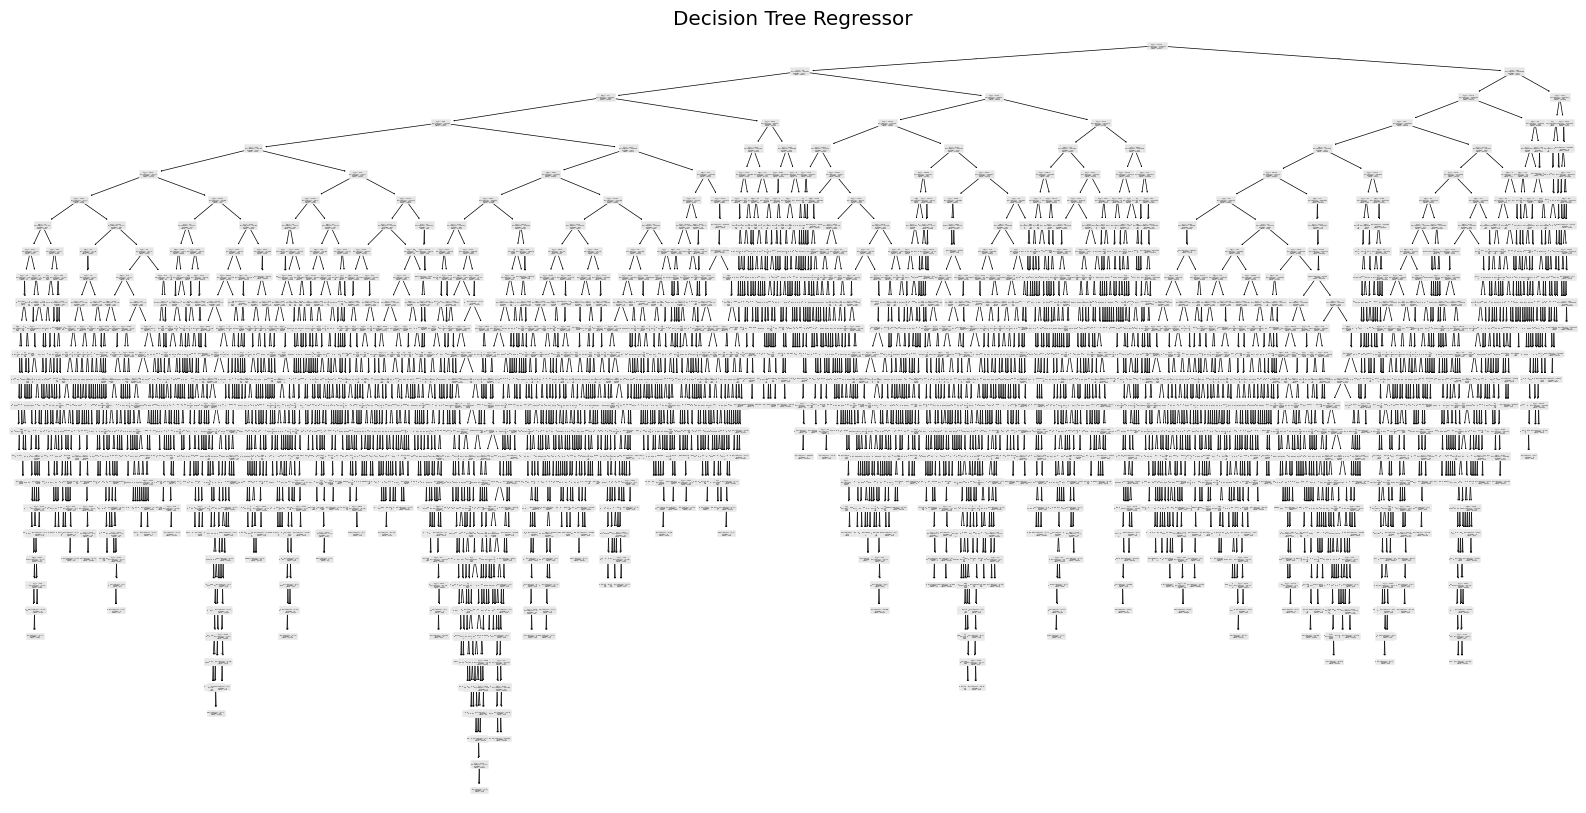

In [40]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(search_tree.best_estimator_)
plt.title('Decision Tree Regressor')
plt.show()

Мать моя......)))

In [41]:
with mlflow.start_run(run_name="DecisionTree"):
    mlflow.log_param("model_type", "DecisionTree")
    mlflow.set_tag("pre_params", json_string)
        
    start_time = datetime.now()
    cutting_tree = DecisionTreeRegressor(random_state=42, 
                                         **search_tree.best_params_)
    cutting_tree.fit(X,y)
    cutting_tree_predict = cutting_tree.predict(exp1_X_test[tree_features])
    compare['y_cutting_tree_exp1_predict'] = cutting_tree_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    cutting_tree_metrics = get_and_print_metrics(cutting_tree_predict, exp1_y_test)     
    
    for key, value in cutting_tree_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(cutting_tree, "cutting_tree_model")

RMSE: 12.491124699852316
MAPE: 14.09%
SMAPE: 12.23%
R2: 0.91
Процент значений с ошибкой не более 20%: 81.85%
WAPE: 13.14%


2024/09/17 21:14:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Сравнение с baseline

In [42]:
base_metrics['model_name'] = 'base'
cutting_tree_metrics['model_name'] = 'decision_tree'

metrics_dicts = [
    base_metrics,
    cutting_tree_metrics,
]

# Создаем DataFrame из списка словарей
compare_metrics = pd.DataFrame(metrics_dicts)

# Переименуем столбец 'model_name' в индекс DataFrame
compare_metrics.set_index('model_name', inplace=True)

compare_metrics

,rmse,mape,smape,R2,percentage_within_20,wape
model_name,,,,,,
base,35.392,0.480,39.181,0.310,43.131,41.873
decision_tree,12.491,0.141,12.234,0.914,81.852,13.141


Для сравнения, посмотрим на графике, как распределены ошибки (в процентах)

In [43]:
def get_percent_error(pred, fact):
    error = abs(fact - pred)
    return error / fact * 100

In [44]:
compare['base_percent_error'] = compare.apply(lambda x: get_percent_error(x['base_y_pred'], x['Time']), axis=1)
compare['tree_percent_error'] = compare.apply(lambda x: get_percent_error(x['y_cutting_tree_exp1_predict'], x['Time']), axis=1)

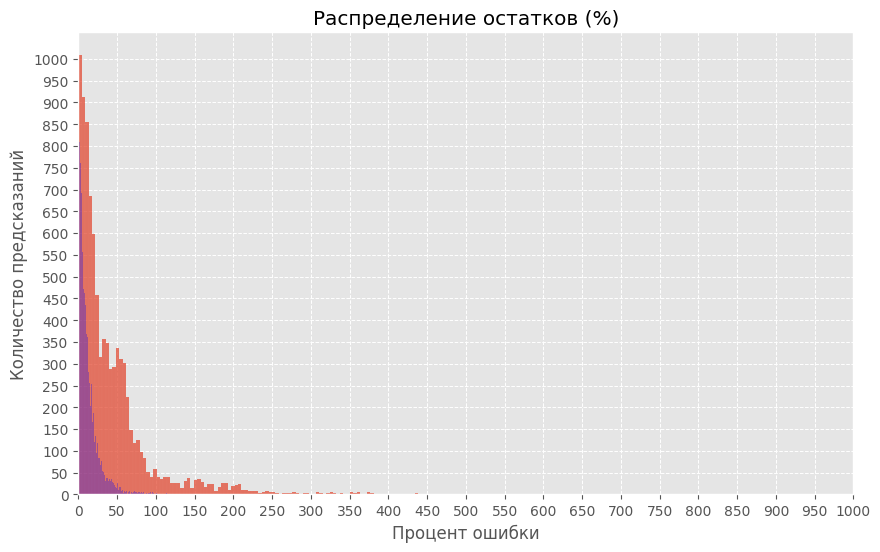

In [45]:
# Построение гистограммы с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(compare, x='base_percent_error')
sns.histplot(compare, x='tree_percent_error', color='blue', alpha=0.3)

# Ограничиваем значения по оси X до 1000
plt.xlim(0,1000)

# Задаем шаг для меток оси X (например, шаг 100)
step = 50
plt.xticks(np.arange(0, 1001, step))
plt.yticks(np.arange(0, 1001, step))

# Включаем сетку и задаем тот же шаг
plt.grid(True, axis='x', which='both', linestyle='--', linewidth=0.7)
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)


# Добавим подписи и заголовок (если нужно)
plt.xlabel('Процент ошибки')
plt.ylabel('Количество предсказаний')
plt.title('Распределение остатков (%)')

plt.show()

## Случайный лес

In [46]:
from scipy.stats import randint
from sklearn.utils import resample

In [47]:
# Выбираем случайную подвыборку из 10% данных для поиска гиперпараметров
X_subset, y_subset = resample(X, y, replace=False, n_samples=int(len(X)*0.1))

param_distributions = {
    'n_estimators': randint(50, 100), 
    'max_depth': list(range(10, 30)), 
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt']
}

# Создание модели и RandomizedSearchCV
forest_model = RandomForestRegressor(random_state=42)
forest_search = RandomizedSearchCV(estimator=forest_model, param_distributions=param_distributions,
                                   random_state=42, n_iter=5, cv=3, n_jobs=-1)

# Запуск поиска лучших параметров на подмножестве данных
forest_search.fit(X_subset, y_subset)

# Вывод лучших параметров и лучшей оценки
print("Лучшие параметры:", forest_search.best_params_)

Лучшие параметры: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 71}


In [48]:
with mlflow.start_run(run_name="RandomForest"):
    mlflow.log_param("model_type", "RandomForest")
    mlflow.set_tag("pre_params", json_string)
        
    start_time = datetime.now()
    forest = RandomForestRegressor(random_state=42, 
                                         **forest_search.best_params_)
    forest.fit(X,y)
    forest_predict = forest.predict(exp1_X_test[tree_features])
    compare['y_forest_exp1_predict'] = forest_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    forest_metrics = get_and_print_metrics(forest_predict, exp1_y_test)     
    
    for key, value in forest_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(cutting_tree, "cutting_forest_model")

RMSE: 14.236184485874022
MAPE: 18.70%
SMAPE: 15.54%
R2: 0.89
Процент значений с ошибкой не более 20%: 72.82%
WAPE: 15.88%


2024/09/17 21:15:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


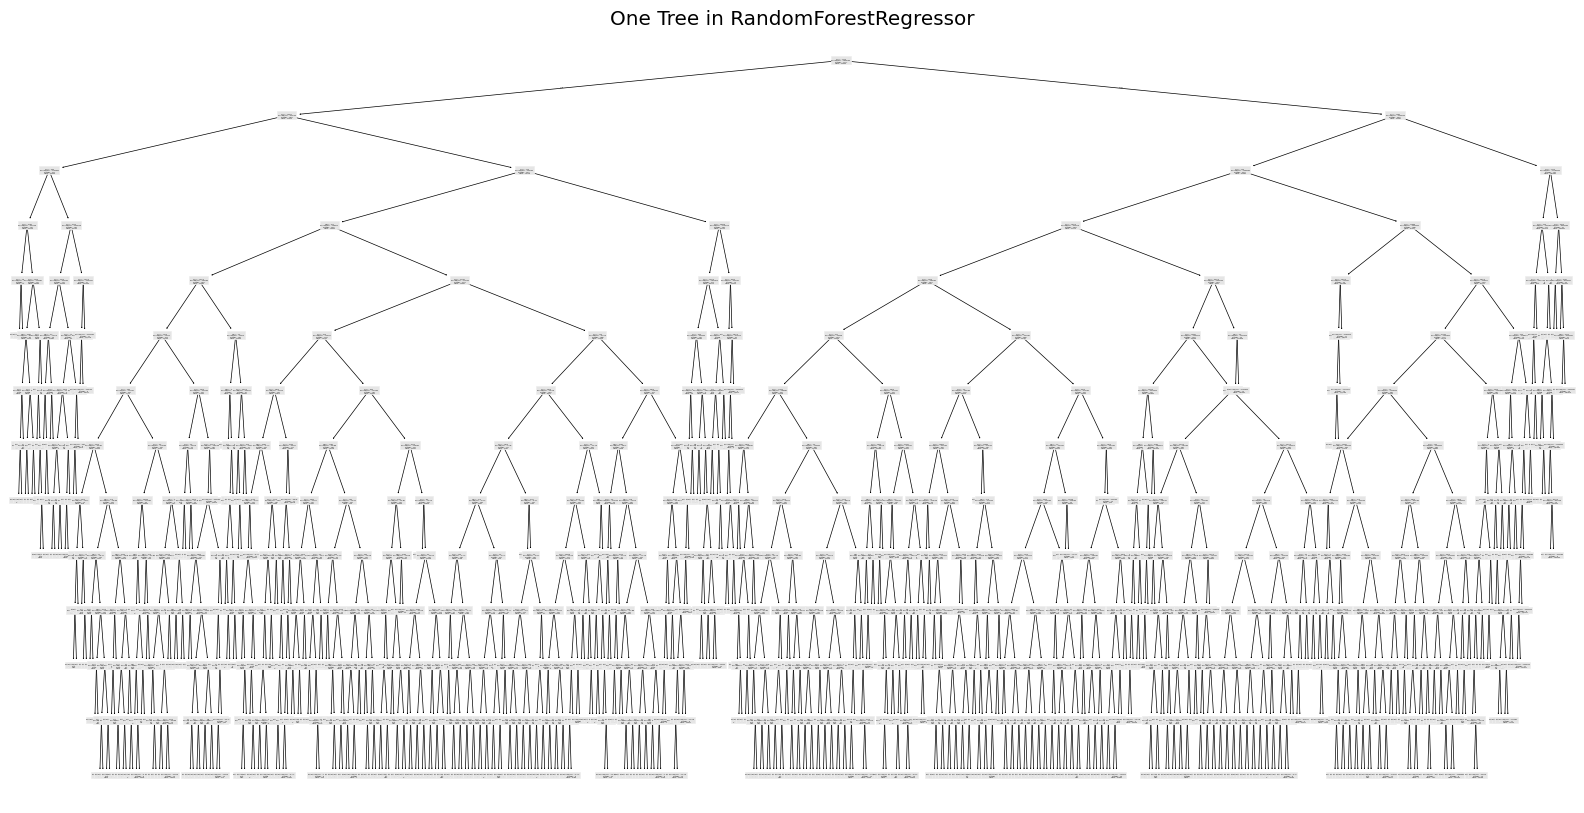

In [49]:
# Визуализация одного из деревьев в случайном лесе
plt.figure(figsize=(20, 10))
plot_tree(forest.estimators_[0])
plt.title('One Tree in RandomForestRegressor')
plt.show()

In [50]:
compare['base_percent_error'] = compare.apply(lambda x: get_percent_error(x['base_y_pred'], x['Time']), axis=1)
compare['forest_percent_error'] = compare.apply(lambda x: get_percent_error(x['y_forest_exp1_predict'], x['Time']), axis=1)

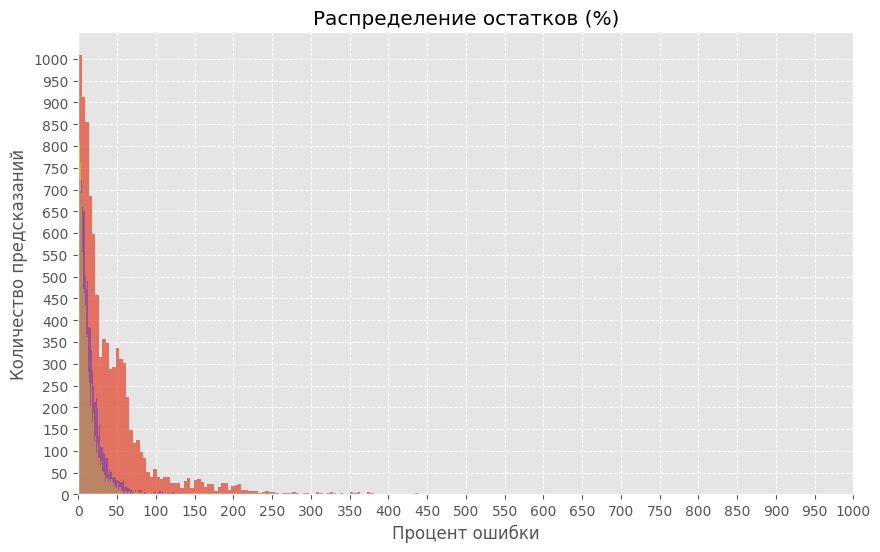

In [51]:
# Построение гистограммы с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(compare, x='base_percent_error')
sns.histplot(compare, x='forest_percent_error', color='blue', alpha=0.3)
sns.histplot(compare, x='tree_percent_error', color='yellow', alpha=0.3)


# Ограничиваем значения по оси X до 1000
plt.xlim(0,1000)

# Задаем шаг для меток оси X (например, шаг 100)
step = 50
plt.xticks(np.arange(0, 1001, step))
plt.yticks(np.arange(0, 1001, step))

# Включаем сетку и задаем тот же шаг
plt.grid(True, axis='x', which='both', linestyle='--', linewidth=0.7)
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)


# Добавим подписи и заголовок (если нужно)
plt.xlabel('Процент ошибки')
plt.ylabel('Количество предсказаний')
plt.title('Распределение остатков (%)')

plt.show()